<div style="width: 100%; clear: both;">

<div style="float: left; width: 50%;">

<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" align="left">

</div>

<div style="float: right; width: 50%;">

<p style="margin: 0; padding-top: 22px; text-align:right;">M2.991 · Aprenentatge automàtic · PAC3</p>

<p style="margin: 0; text-align:right;">2024-2 · Màster universitari en Ciència de dades (Data science)</p>

<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicació</p>

</div>

</div>

<div style="width:100%;">&nbsp;</div>

# PEC 3: Mètodes supervisats

En aquesta pràctica veurem diferents mètodes supervisats i mirarem d'optimitzar diferents mètriques. Veurem com els diferents models classifiquen les observacions i amb quins obtenim un rendiment més alt. Després aplicarem tot el que hem après fins ara a un dataset nou simulant un cas pràctic real.

1.  [Exploració d'algorismes supervisats](#ej1)

    1.1. [Càrrega de dades](#ej1)

    1.2. [K veïns més propers (KNN)](#ej12)

    1.3. [Màquines de vectors de suport (SVM)](#ej13)

    1.4. [Arbres de decisió](#ej14)

2.  [Comprensió d'algorismes supervisats](#ej2)

3.  [Implementació del cas pràctic](#ej3)

    2.1. [Càrrega de dades](#ej31)

    2.2. [Anàlisi Exploratòria de Dades](#ej32)

    2.3. [Preprocessament de Dades](#ej33)
    
    2.4. [Modelització](#ej34)

<u>Consideracions generals</u>:

- La solució plantejada no pot utilitzar mètodes, funcions o paràmetres declarats **_deprecated_** en futures versions, a excepció de la càrrega de dades com s'indica posteriorment.
- Aquesta PAC s'ha de realitzar de forma **estrictament individual**. Qualsevol indici de còpia serà penalitzat amb un suspens (D) per a totes les parts implicades i la possible avaluació negativa de l'assignatura de forma íntegra.
- Cal que l'estudiant indiqui **totes les fonts** que ha utilitzat per a la realització de la PAC. En cas contrari, es considerarà que l'estudiant ha comès plagi, i serà penalitzat amb un suspens (D) i la possible avaluació negativa de l'assignatura de forma íntegra.

<u>Format del lliurament</u>:

- Alguns exercicis poden suposar diversos minuts d'execució, per la qual cosa el lliurament s'ha de fer en **format notebook** i en **format html**, on es vegi el codi, els resultats i els comentaris de cada exercici. Es pot exportar el notebook a HTML des del menú File $\to$ Download as $\to$ HTML.
- Hi ha un tipus de cel·la especial per allotjar text. Aquest tipus de cel·la us serà molt útil per respondre a les diferents preguntes teòriques plantejades al llarg de l'activitat. Per canviar el tipus de cel·la a aquest tipus, al menú: Cell $\to$ Cell Type $\to$ Markdown.

<div class="alert alert-block alert-info">
    <strong>Nom i cognoms: Marc Cervera Rosell</strong>
</div>

In [1]:
!pip install kagglehub==0.3.12

In [2]:
!pip install umap-learn==0.5.6

In [3]:
import os
import tqdm
import kagglehub
import umap

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

from sklearn import datasets
from sklearn import tree
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score

%matplotlib inline

<a id='ej1'></a>
# 1. Exploració d'algorismes supervisats (3.75 punts)

## 1.1. Càrrega de dades

L'enfonsament del Titanic és un dels naufragis més tristament cèlebres de la història. El 15 d'abril de 1912, durant el seu viatge inaugural, el considerat «insubmergible» RMS Titanic es va enfonsar després de xocar amb un iceberg. Malauradament, no hi havia suficients bots salvavides per a tots els ocupants, la qual cosa va provocar la mort de 1.502 dels 2.224 passatgers i tripulants. Tot i que hi va haver una mica de sort en la supervivència, sembla que alguns grups de persones van tenir més probabilitats de sobreviure que d'altres.

En aquest exercici treballarem amb el conjunt de dades [Titanic-Dataset](https://www.kaggle.com/datasets/yasserh/titanic-dataset?select=Titanic-Dataset.csv), el qual conté la descripció d'una part dels passatgers i tripulants del Titanic.

El codi següent carregarà les dades dels passatgers i en realitzarà una transformació. De cada passatger tenim informació diversa (conjunt X) com l'edat o la categoria en la qual viatjava, així com la variable objectiu (y), que indica si la persona va sobreviure o no al tràgic accident. Podem comprovar que la càrrega ha estat correcta obtenint les dimensions d'aquests dos conjunts.

In [4]:
root_path = kagglehub.dataset_download("yasserh/titanic-dataset")
dataset_path = os.path.join(root_path, "Titanic-Dataset.csv")
data = pd.read_csv(dataset_path)

data = data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
data = data.dropna()

n_classes = 2
labels = ['No', 'Yes']
categorical_columns = ['Sex', 'Embarked']

cat_df = pd.get_dummies(data[categorical_columns], dtype=int)
data = pd.concat([data, cat_df], axis=1, join="inner")
data = data.drop(columns=categorical_columns)

X = data.drop(columns=['Survived'])
y = data['Survived']

print("Vector X Dimensions: {}".format(X.shape))
print("Vector y Dimensions: {}".format(y.shape))

Vector X Dimensions: (712, 10)
Vector y Dimensions: (712,)


Abans de començar a treballar amb el problema, és important analitzar si el conjunt de dades està desbalancejat. En la gràfica següent podem comprovar que no hi ha una desviació elevada, (60/40) aproximadament.

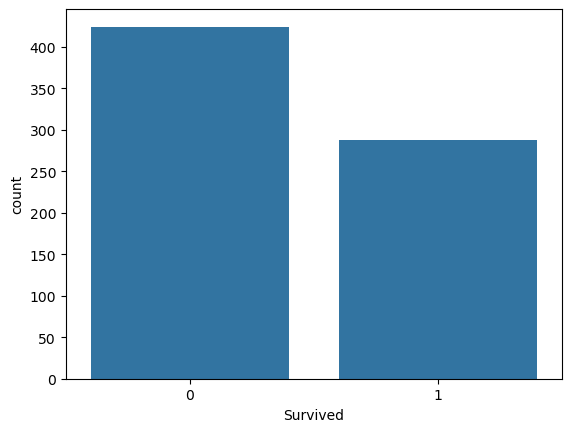

In [5]:
sns.countplot(x='Survived', data=data)
plt.show()

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong>

Dividiu el _dataset_ en dos subconjunts, **_train_** (80% de les dades) i **_test_** (20% de les dades). Anomeneu els conjunts com: X_train, X_test, y_train, y_test. Utilitzeu l'opció `random_state = 24`.

Podeu utilitzar la implementació `train_test_split` de `sklearn`.

</div>

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=24 # 0.2 = 20% per a test -> 0.8 = 80% per a train
)

Per poder visualitzar els resultats de cada algorisme supervisat, reduirem el dataset anterior a dues dimensions.

**NOTA**: Aquest exercici s'ha plantejat des d'un punt de vista didàctic, per la qual cosa utilitzarem en tot l'exercici el dataset reduït a dues dimensions amb l'objectiu de visualitzar les fronteres de decisió dels models. Aplicar directament reducció de la dimensionalitat no té per què ser la millor tècnica o aproximació per abordar el problema d'aprenentatge supervisat. No obstant això, ens servirà per visualitzar i aprofundir en l'enteniment sobre les fronteres que aprenen els diferents models.

C:\Users\mcr99\anaconda3\envs\environment_uoc20242pec3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


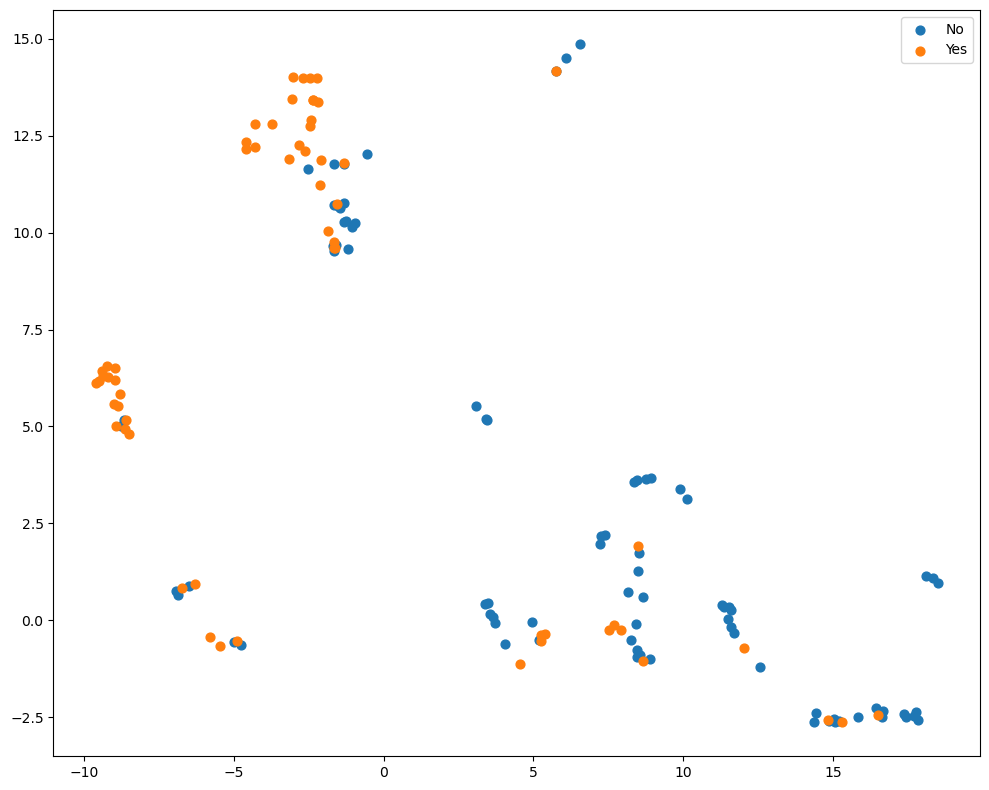

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = umap.UMAP(n_components=2, random_state=42, n_jobs=-1)
model.fit(X_train)
X_train_projection = model.transform(X_train)
X_test_projection = model.transform(X_test)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i in range(n_classes):
    ax.scatter(X_test_projection[y_test == i,0], X_test_projection[y_test == i,1], s=40, marker='o', label=labels[i])
plt.legend()
plt.tight_layout()

plt.show()

Al llarg de l'exercici aprendrem a veure gràficament les fronteres de decisió que ens retornen els diferents models. Per fer-ho utilitzarem la funció definida a continuació, que segueix els passos següents:

1.  Crear una *meshgrid* amb els valors mínim i màxim de 'x' i 'y'.
2.  Predir el classificador amb els valors de la *meshgrid*.
3.  Fer un *reshape* de les dades per tenir el format corresponent.

Un cop fet això, ja podem fer el gràfic de les fronteres de decisió i afegir els punts reals. Així veurem les àrees que el model considera que són d'una classe i les que considera que són d'una altra. En posar a sobre els punts veurem si els classifica correctament a l'àrea que els correspon.

In [8]:
# Define the function that will visualize the decision boundary
def plot_decision_boundaries(model, X_test_projection, y_test):

    # Create the meshgrid with the minimum and maximum values of the x and y axes
    x_min, x_max = X_test_projection[:, 0].min() - 1, X_test_projection[:, 0].max() + 1
    y_min, y_max = X_test_projection[:, 1].min() - 1, X_test_projection[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                         np.arange(y_min, y_max, 0.05))

    # Prediction by using all values of the meshgrid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Define the colors (one for each class)
    cmap_light = ListedColormap(['gainsboro','lightgreen','peachpuff','lightcyan', 'pink'])
    cmap_bold = ['g','sandybrown','c','palevioletred']

    # Draw the borders
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(20,10))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Draw the points
    for i in range(n_classes):
        plt.scatter(X_test_projection[y_test == i,0], X_test_projection[y_test == i,1],
                    s=40, marker='o', label=labels[i], c=cmap_bold[i])
    plt.legend()
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

**Material extern consultat:**

[scikit-learn.(nd)._train_test_split_.scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

<a id='ej12'></a>
## 1.2. KNN (1.25 punts)

En aquest punt, entendràs el funcionament de l'algorisme KNN (K-Nearest-Neighbor), que es basa en la proximitat dels punts de dades en un espai de característiques. Analitzaràs els seus avantatges i desavantatges, i comprendràs com els paràmetres que el componen influeixen en el seu comportament.

KNN és un algorisme de tipus supervisat basat en instància. Això significa:

- Supervisat: El teu conjunt de dades d'entrenament està etiquetat amb la classe o el resultat esperat.
- Basat en instància (*Lazy Learning*): L'algorisme no aprèn explícitament un model, com en la Regressió Logística o els arbres de decisió. En canvi, memoritza les instàncies d'entrenament i les utilitza com a "coneixement" en la fase de predicció.

Per entendre com funciona KNN, segueix aquests passos:

1.  Calcula la distància entre l'ítem a classificar i els altres ítems del dataset d'entrenament.
2.  Selecciona els "k" elements més propers, és a dir, aquells amb la distància més petita, segons el tipus de distància que utilitzis (euclidiana, cosinus, Manhattan, etc.).
3.  Realitza una "votació de majoria" entre els k punts seleccionats: la classe que predomini en aquests punts decidirà la classificació final de l'ítem analitzat.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong>

Realitza els passos següents amb el dataset d'entrenament (_train_):

1.  Entrena un classificador KNN amb l'hiperparàmetre `n_neighbors=2` utilitzant el classificador `KNeighborsClassifier` de `sklearn`.
2.  Calcula l'_accuracy_ (precisió) del model tant en les dades de _train_ com de _test_.
3.  Calcula la matriu de confusió utilitzant les dades de _test_.
4.  Representa gràficament la frontera de decisió amb les dades de _test_.

Si en entrenar el classificador apareix un avís (*warning*) i vols ignorar-lo, executa el codi següent abans de l'entrenament:

`import warnings`

`warnings.filterwarnings('ignore', message='^.*will change.*$', category=FutureWarning)`


Això et permetrà avaluar l'efectivitat del model KNN amb `n_neighbors=2` en el teu conjunt de dades, i entendre com es comporta en termes de classificació i separació de classes.
    
    
</div>

In [9]:
import warnings
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore', message='^.*will change.*$', category=FutureWarning)

# Step 1: Crear i entrenar el model KNN
knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(X_train_projection, y_train)

# Step 2: Accuracy del model
predictions_data_training = knn_model.predict(X_train_projection) # Prediccions amb dades d'entrenament
predictions_data_testing = knn_model.predict(X_test_projection) # Predeiccions amb dades de testing
training_accuracy = accuracy_score(y_train, predictions_data_training)
testing_accuracy = accuracy_score(y_test, predictions_data_testing)
print(f"Accuracy dades entrenament: {training_accuracy}\n")
print(f"Accuracy dades testing: {testing_accuracy}")

Accuracy dades entrenament: 0.8611599297012302

Accuracy dades testing: 0.7412587412587412


S'observa una alta _accuracy_ per les dades d'entrenament, però cal tenir en compte que el _dataset_ amb el qual s'està treballant no és molt gran, el fet de tenir aquesta alta _accuracy_ es pot deure a _overfitting_. El fet que el valor de k sigui baix en aquest _dataset_ fa que el model knn sigui més sensible als valors atípics.

Per a les dades de test s'observa una _accuracy_ del 74%. Es pot observar una alta diferència de la mètrica entre les dades d'entrenament i les dades de _testing_ (més d'un 10%). Aquesta alta diferència pot indicar que el model pot "haver-se après" les dades vistes en l'entrenament i no pot fer prediccions del tot correctes amb dades que no ha vist mai, tot i que no es segur del tot. A més per experiències tant acadèmiques com laborals personals del passat es considera que un 74% de precisió en les dades de _test_ és una puntuació molt baixa. En totes les experiències sempre s'ha fixat el límit de _accuracy_ al 70%. És a dir, tota precisió per sota del 70% sempre ha estat indicador de la necessitat de tornar a entrenar el model.

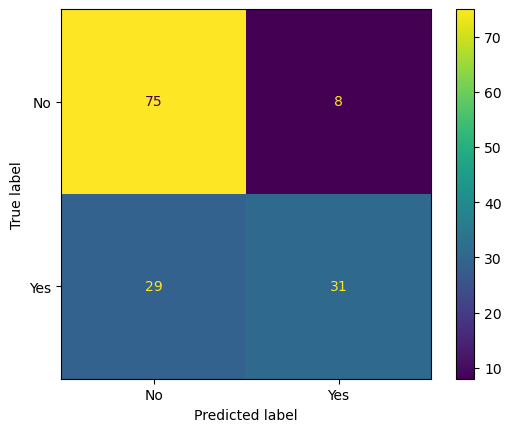

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Step 3: Matriu de confusio
conf_mat = confusion_matrix(y_test, predictions_data_testing)
conf_mat_display = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels) # Per veure la matriu de confusió bonica
conf_mat_display.plot()
plt.show()

Segons la matriu, el model és millor predient quan la gent no va sobreviure, es demostra calculant el _True positive rate_ i el _True negative_rate_:

_True positive rate_ -> Quan realment és "sí", quants cops el model prediu "sí"?

_True negative_rate_ -> Quan realment és "no", quants cops el model prediu "no"?

True positive rate = True positive / actual yes = 31 / (29 + 31) = 51.6%

True negative rate = True negative / actual no = 75 / (75 + 8) = 90.4%

C:\Users\mcr99\anaconda3\envs\environment_uoc20242pec3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


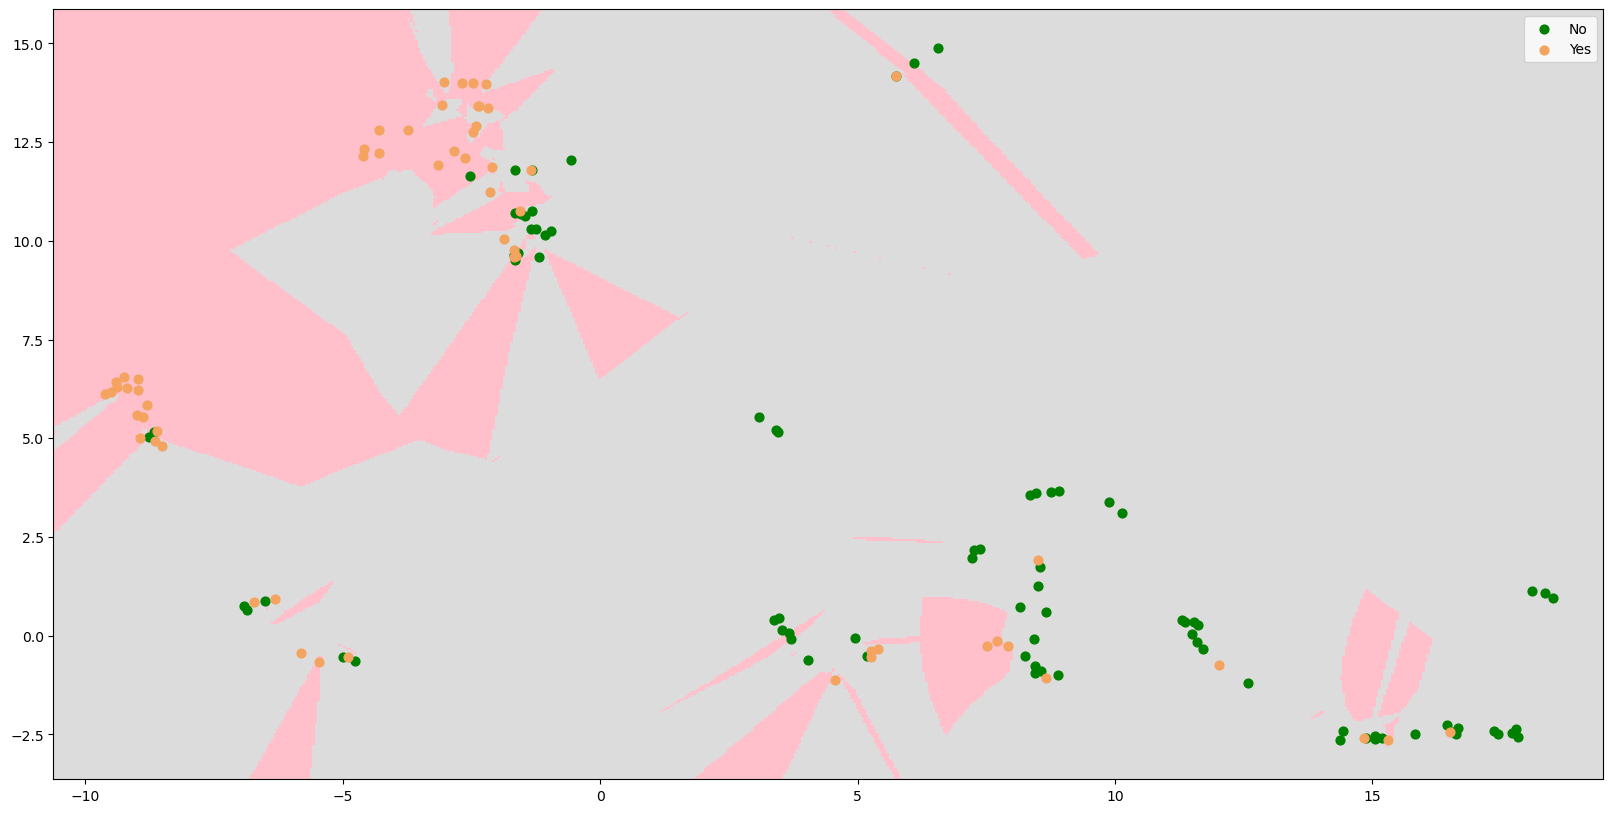

In [11]:
# Step 4: Representar la frontera de decisió de les dades de test
plot_decision_boundaries(knn_model, X_test_projection, y_test)

Observant el gràfic, es pot concloure que les zones rosa són les corresponents a "Yes" i les zones de color gris són les corresponents a la classe "No".

També es confirma el que s'ha vist anteriorment a la matriu de confusió. El model és millor predient quan la gent no va sobreviure.

**Material extern consultat:**

[W3Schools.(nd)._Machine Learning - Confusion Matrix_.W3Schools](https://www.w3schools.com/python/python_ml_confusion_matrix.asp)

[scikit-learn.(nd)._KNeighborsClassifier_.scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) -> Les funcions _fit()_ y _predict()_ queden incloses en aquest enllaç.

[scikit-learn.(nd)._accuracy_score_.scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

[scikit-learn.(nd)._confusion_matrix_.scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

[data school.(25-03-2014)._Simple guide to confusion matrix terminology_. data school](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)

[Iker Landajuela.(2024)._Elección del número de vecinos k_.IA y Big Data](https://iabigdata-soka-4ae9e223e32444ac5ae3d78afbd55fd9aa6da1c19d9679bf.gitlab.io/post/2024-09-22-pia_knn_k_select/)

En el model que has entrenat, has fixat el paràmetre `n_neighbors` de forma arbitrària. No obstant això, és possible que amb un altre valor obtinguis una millor predicció. Per trobar el valor òptim dels paràmetres d'un model (*hyperparameter tunning*), sovint s'utilitza una cerca de reixeta (*grid search*). Això implica entrenar un model per a cada combinació possible d'hiperparàmetres i avaluar-lo mitjançant validació creuada (*cross validation*) amb 5 particions estratificades. Després, seleccionaràs la combinació d'hiperparàmetres que hagi obtingut els millors resultats.

En aquest cas, et centraràs a optimitzar un sol hiperparàmetre:

-   𝑘: el nombre de veïns que es consideren per classificar un nou exemple. Has de provar amb tots els valors entre 1 i 20.

Realitza aquest procés per identificar el nombre òptim de veïns, la qual cosa et permetrà millorar la precisió de les teves prediccions amb el model KNN.

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong>

Per calcular el valor òptim de l'hiperparàmetre _k_ (`n_neighbors`), has de realitzar una cerca de reixeta amb validació creuada. Aquest procés t'ajudarà a trobar el valor òptim de _k_. Per a cada valor, calcula'n la mitjana i la desviació estàndard. Després, implementa un *lineplot* per visualitzar la precisió segons els diferents valors de l'hiperparàmetre.

Utilitza el mòdul `GridSearchCV` de `sklearn` per calcular el millor hiperparàmetre. Per a la visualització del *lineplot*, empra la llibreria `Seaborn`.

Aquests passos et permetran identificar de manera efectiva i visual el valor de _k_ que maximitza la precisió del teu model KNN.
</div>

In [12]:
knn_model = KNeighborsClassifier()
grid = GridSearchCV(estimator=knn_model, param_grid={'n_neighbors': list(range(1, 21))}, cv=5, scoring='accuracy', return_train_score=True)
grid.fit(X_train_projection, y_train) # Entrenament dels diferents models

C:\Users\mcr99\anaconda3\envs\environment_uoc20242pec3\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20]},
             return_train_score=True, scoring='accuracy')

In [33]:
import pandas as pd
import seaborn as sns
# Resultats dels models entrenats
df_results = pd.DataFrame(grid.cv_results_) # splitX_test_score = accuracy de cada split de la grid search
df_results[["param_n_neighbors", "mean_train_score", "std_train_score", "mean_test_score", "std_test_score"]]

,param_n_neighbors,mean_train_score,std_train_score,mean_test_score,std_test_score
0,1,1.000000,0.000000,0.732837,0.022932
1,2,0.861601,0.003604,0.746949,0.024806
2,3,0.871264,0.002329,0.783853,0.015974
3,4,0.853685,0.007270,0.799674,0.016717
4,5,0.855885,0.004162,0.785561,0.032817
5,6,0.845340,0.005726,0.792610,0.012031
6,7,0.842263,0.010021,0.792610,0.021273
7,8,0.834351,0.009801,0.808415,0.021242
8,9,0.834796,0.008195,0.806645,0.020341
9,10,0.835673,0.008455,0.803136,0.014634


Gràcies a la funció _cv_results__ els càlculs de les mitjanes i les desviacions es fan de manera automàtica. A més aquesta funció també proporciona dades de la _accuracy_ per totes i cadascuna de les particions, tant per les dades d'entrenament com per les de _test_.

In [34]:
# Visualitzacio en un line plot
data_to_plot = df_results[['param_n_neighbors', 'mean_test_score']] # Dades que volem graficar
data_to_plot.columns = ['k', 'accuracy'] # Renombrar columnes
data_to_plot.head()

,k,accuracy
0,1,0.732837
1,2,0.746949
2,3,0.783853
3,4,0.799674
4,5,0.785561


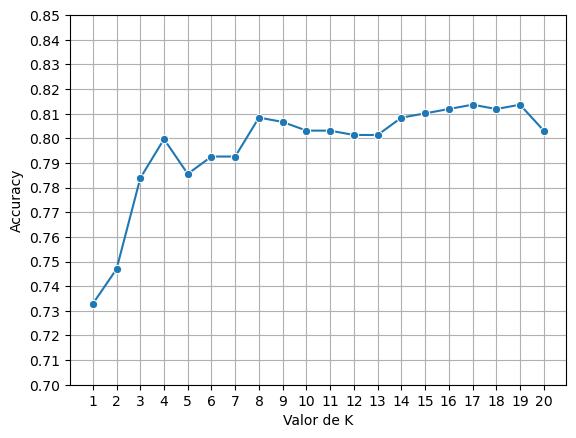

In [55]:
import numpy as np
plt.figure()
sns.lineplot(data=data_to_plot, x='k', y='accuracy', marker='o')
plt.xlabel("Valor de K")
plt.ylabel("Accuracy")
plt.xticks(range(1, 21))
plt.yticks(np.arange(0.7, 0.85, 0.01))
plt.grid()
plt.show()

Observant tant el gràfic com la taula de resultats proporcionada per la funció _cv_results_, es pot observar que el valor de k que millor funciona és 17.

**Material extern consultat:**

[scikit-learn.(nd)._GridSearchCV_.scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) -> Aquest enllaç inclou, també, les funcions _fit()_ i _cv_results__.

[Pandas.(nd)._pandas.DataFrame_.Pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)

[Seaborn.(nd)._seaborn.lineplot_.Seaborn](https://seaborn.pydata.org/generated/seaborn.lineplot.html)

[Diversos autors.(diverses dates)._Plot point markers and lines in different hues but the same style with seaborn_.StackOverflow](https://stackoverflow.com/questions/52385428/plot-point-markers-and-lines-in-different-hues-but-the-same-style-with-seaborn)

[Diversos autors.(diverses dates)._How can I add grid lines to a catplot in seaborn?_.StackOverflow](https://stackoverflow.com/questions/61503183/how-can-i-add-grid-lines-to-a-catplot-in-seaborn)

[Vishal Hule.(13/04/2021)._Python range of float numbers_.PYnative Python Programming](https://pynative.com/python-range-for-float-numbers/)

<div class="alert alert-block alert-info">
<strong>Implementació:</strong>

Segueix aquests passos amb el dataset d'entrenament (_train_):

1.  Entrena un classificador KNN utilitzant el millor hiperparàmetre que hagis trobat.
2.  Calcula l'_accuracy_ (precisió) del model tant en les dades de _train_ com de _test_.
3.  Calcula la matriu de confusió utilitzant les dades de _test_.
4.  Representa gràficament la frontera de decisió amb les dades de _test_.

Aquest procés et permetrà veure com l'hiperparàmetre òptim que has identificat millora l'efectivitat del teu model KNN en la classificació de les dades.
</div>

In [59]:
warnings.filterwarnings('ignore', message='^.*will change.*$', category=FutureWarning)

# Step 1: Crear i entrenar el model KNN
knn_optimal = KNeighborsClassifier(n_neighbors=17)
knn_optimal.fit(X_train_projection, y_train)

# Step 2: Accuracy del model
predictions_data_training = knn_optimal.predict(X_train_projection) # Prediccions amb dades d'entrenament
predictions_data_testing = knn_optimal.predict(X_test_projection) # Predeiccions amb dades de testing
training_accuracy = accuracy_score(y_train, predictions_data_training)
testing_accuracy = accuracy_score(y_test, predictions_data_testing)
print(f"Accuracy dades entrenament: {training_accuracy}\n")
print(f"Accuracy dades testing: {testing_accuracy}")

Accuracy dades entrenament: 0.827768014059754

Accuracy dades testing: 0.8041958041958042


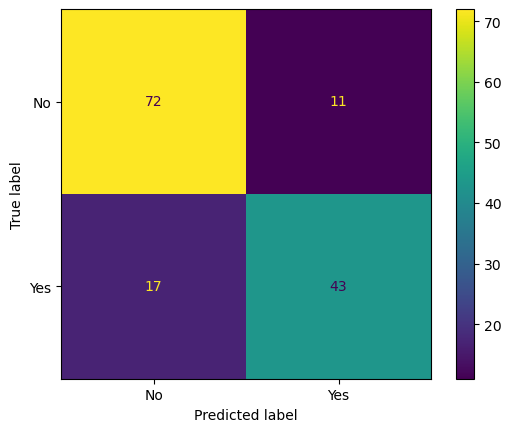

In [60]:
# Step 3: Matriu de confusio
conf_mat = confusion_matrix(y_test, predictions_data_testing)
conf_mat_display = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels) # Per veure la matriu de confusió bonica
conf_mat_display.plot()
plt.show()

_True positive rate_ = 43 / (17 + 43) = 71.6%

_True negative rate_ = 72 / (72 + 11) = 86.7%

C:\Users\mcr99\anaconda3\envs\environment_uoc20242pec3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


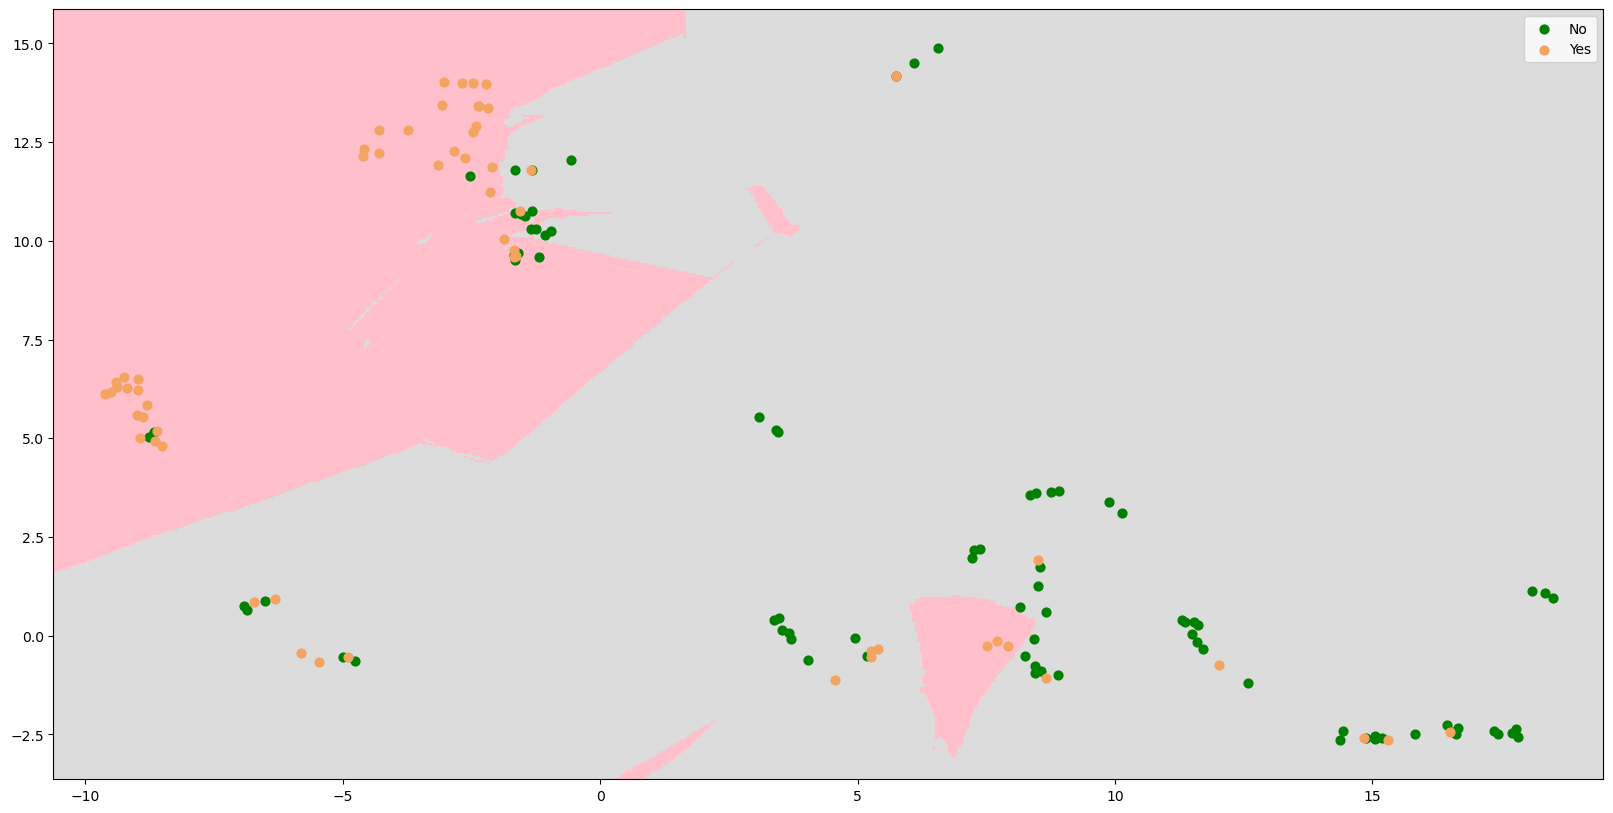

In [61]:
# Step 4: Representar la frontera de decisió de les dades de test
plot_decision_boundaries(knn_optimal, X_test_projection, y_test)

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong>

1.  Comenta els resultats obtinguts en la cerca del millor hiperparàmetre. Reflexiona sobre com va variar el rendiment del model amb els diferents valors de `n_neighbors`.
2.  Analitza com es visualitza gràficament el canvi del valor de `n_neighbors`. Observes alguna tendència o patró clar? És coherent aquesta diferència entre els dos gràfics en canviar el paràmetre?
3.  Examina les fronteres de decisió que has generat. La forma d'aquestes fronteres té sentit donat l'algorisme KNN utilitzat? Pensa en com l'elecció del nombre de veïns influeix en la forma de la frontera.
4.  Avalua les prediccions realitzades sobre el conjunt de test. Observa'n la precisió i com es distribueixen en relació amb les fronteres de decisió. Són consistents aquestes prediccions amb el que observes a les fronteres de decisió?

Aquesta anàlisi t'ajudarà a comprendre l'eficàcia del model KNN amb diferents configuracions de `n_neighbors` i el seu impacte en la classificació de les dades.
</div>

<div class="alert alert-block alert-success">
<strong>Resposta:
    
Anàlisi punt 1 -> S'ha observat que en el primer model knn (k = 2) la accuracy del model per a les dades d'entrenament era d'un 86% aproximadament però per a les dades de test ha estat d'un 74%, aproximadament. És una diferència molt notòria entre ambdues puntuacions, cosa que podria indicar que el model està sobre ajustat. En canvi, amb el valor de k = 17, aquesta gran diferència entre accuracies desapareix atès que la accuracy d'entrenament és, aproximadament, d'un 82% i la de testing és d'un 80%. Aquesta petita diferència fa pensar que el model no està patint overfitting.

Anàlisi punt 2 -> Analitzant el gràfic de com varia l'accuracy segons el valor de k, no s'observa cap patró evident, però sí que es pot observar que per valors de k entre 1 i 20 els millors valors que pot obtenir l'hiperparàmetre són 17 o 20. Només observant el gràfic no es pot decidir quin és el millor d'aquests dos. Per prendre la decisió cal mirar la taula de resultats amb les mitjanes i les desviacions.

Anàlisi punt 3 -> En el cas del model amb un valor de k petit, s'observen unes fronteres irregulars (punxegudes) amb moltes "illes frontera". En el cas del model amb k = 17, les fronteres són més suaus i no hi ha tantes "illes frontera". Per tant, atesos els valors de k, es pot concloure que les fronteres, cadascuna per al seu model, tenen sentit.

Anàlisi punt 4 -> Per analitzar les prediccions cal mirar les matrius de confusió d'ambdós models. Quan la resposta es "sí" el model prediu "sí" un 51.6% de les vegades enfront del 71.6% del segon model. En el cas que la resposta sigui "no" el primer model prediu "no" el 90.4% de les vegades i el segon model, el 86.7% de les vegades. Per tant, es pot observar que el primer model és més bo predient quan la gent no va sobreviure i el segon model també és millor predient quan la gent va morir. El que s'observa en el cas de les prediccions "sí" s'observa que el primer model (k = 2) realitza correctament el 51.6% de les vegades mentre que el segon model (k = 17) ho fa el 71.6% de les vegades. Aquests percentatges indiquen que el segon model (k = 17) està més equilibrat. El primer model (k = 2) prediu les respostes "sí" quasi de manera aleatòria (51.6%).
</strong>


</div>

<a id='ej13'></a>
## 1.3. SVM (1.25 punts)

En aquesta secció, exploraràs les Màquines de Vectors de Suport (SVM), que es basen en el concepte del *Maximal Margin Classifier* i l'hiperplà.

Un hiperplà en un espai p-dimensional es defineix com un subespai pla i afí de dimensions p-1. En dues dimensions, és una recta; en tres, un pla convencional. Per a dimensions superiors a tres, tot i que no és intuïtiu visualitzar-lo, el concepte es manté.

Quan els casos són perfectament separables de manera lineal, sorgeixen infinits possibles hiperplans. Per seleccionar el classificador òptim, utilitza el concepte de *maximal margin hyperplane*, l'hiperplà que es troba més allunyat de totes les observacions d'entrenament. Aquest es defineix calculant la distància perpendicular mínima (marge) de les observacions a un hiperplà. L'hiperplà òptim és aquell que maximitza aquest marge.

En el procés d'optimització, has de tenir en compte que només les observacions al marge o que el violen (vectors de suport) influeixen en l'hiperplà. Aquests vectors de suport són els que defineixen el classificador.

#### Els *kernels* en SVM

En situacions on no pots trobar un hiperplà que separi dues classes, és a dir, quan les classes no són linealment separables, pots utilitzar el truc del nucli (*kernel trick*). Aquest mètode et permet treballar en una dimensió nova on és possible trobar un hiperplà per separar les classes.

Igual que amb el KNN, les SVM també depenen de diversos hiperparàmetres. En aquest cas, et centraràs a optimitzar dos hiperparàmetres:

1.  **C**: la regularització, que és el valor de penalització dels errors en la classificació. Aquest valor indica el compromís entre obtenir l'hiperplà amb el marge més gran possible i classificar correctament el màxim nombre d'exemples. Has de provar els valors següents: 0.01, 0.1, 1, 10, 50, 100 i 200.

2.  **Gamma**: un coeficient que multiplica la distància entre dos punts en el kernel radial. En termes simples, com més petit sigui gamma, més influència tindran dos punts propers. Has de provar els valors: 0.001, 0.01, 0.1, 1 i 10.

Per validar el rendiment de l'algorisme amb cada combinació d'hiperparàmetres, utilitza la validació creuada (*cross-validation*) amb 5 particions estratificades.

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong>


1.  Calcula el valor òptim dels hiperparàmetres _C_ i _gamma_ utilitzant una cerca de reixeta amb validació creuada. Aquest procés t'ajudarà a trobar els valors òptims.
2.  Per a cada combinació de valors, calcula'n la mitjana i la desviació estàndard.
3.  Fes un *heatmap* per visualitzar la precisió segons els diferents valors dels hiperparàmetres.

Utilitza el mòdul `GridSearchCV` de `sklearn` per calcular els millors hiperparàmetres amb el classificador SVC (de `SVM` de `sklearn`). Per a la visualització del *heatmap*, empra la llibreria `Seaborn`.

Aquests passos et permetran identificar de manera efectiva i visual els valors de _C_ i _gamma_ que maximitzen la precisió del teu model SVM.
</div>

In [64]:
from sklearn.svm import SVC
params = {"C":[0.01, 0.1, 1, 10, 50, 100, 200], "gamma":[0.001, 0.01, 0.1, 1, 10]} 
svm = SVC()
grid_svm = GridSearchCV(estimator=svm, param_grid=params, cv=5, scoring='accuracy', return_train_score=True)
grid_svm.fit(X_train_projection, y_train) # Entrenament dels diferents models

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 50, 100, 200],
                         'gamma': [0.001, 0.01, 0.1, 1, 10]},
             return_train_score=True, scoring='accuracy')

In [65]:
print(grid_svm.best_params_)

{'C': 1, 'gamma': 1}


Com es pot observar en la cèl·la anterior, els millors valors de "C" i "gamma" són 1 en ambdós casos.

In [70]:
# Resultats dels models entrenats
df_results = pd.DataFrame(grid_svm.cv_results_) # splitX_test_score = accuracy de cada split de la grid search
df_results[["param_C", "param_gamma", "mean_train_score", "std_train_score", "mean_test_score", "std_test_score"]]

,param_C,param_gamma,mean_train_score,std_train_score,mean_test_score,std_test_score
0,0.01,0.001,0.599297,0.000905,0.599301,0.003615
1,0.01,0.010,0.599297,0.000905,0.599301,0.003615
2,0.01,0.100,0.599297,0.000905,0.599301,0.003615
3,0.01,1.000,0.599297,0.000905,0.599301,0.003615
4,0.01,10.000,0.599297,0.000905,0.599301,0.003615
5,0.10,0.001,0.724076,0.010773,0.724049,0.043010
6,0.10,0.010,0.780311,0.009331,0.780236,0.037363
7,0.10,0.100,0.779873,0.009859,0.773218,0.036609
8,0.10,1.000,0.811946,0.006728,0.804906,0.020444
9,0.10,10.000,0.652015,0.010288,0.627418,0.008783


Observant la taula de resultats, es confirma la hipòtesi de que els millors valors són C = 1 i gamma = 1

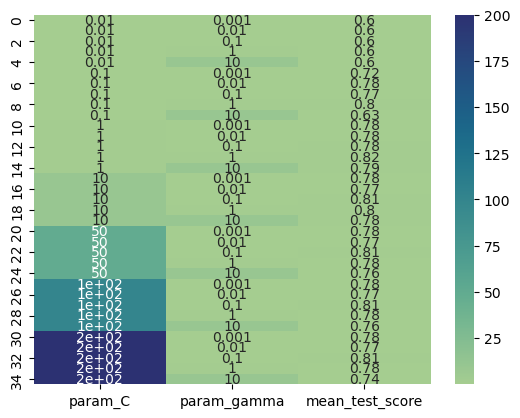

In [81]:
results_svm_to_plot = df_results[["param_C", "param_gamma", "mean_test_score"]]
matrix_data_to_plot = results_svm_to_plot.pivot(index="param_C", columns="param_gamma", values="mean_test_score")
plt.figure()
sns.heatmap(results_svm_to_plot, annot=True, cmap='crest')
plt.show()

**Material extern consultat:**

[scikit-learn.(nd)._SVC_.scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

[scikit-learn.(nd)._GridSearchCV_.scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) -> En aquesta ocasió s'ha consultat la funció _best_params__

[seaborn.(nd)._seaborn.heatmap_.seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

<div class="alert alert-block alert-info">
<strong>Implementació:</strong>

Realitza els passos següents amb el dataset d'entrenament (_train_):

1.  Entrena un model SVM utilitzant la millor combinació de paràmetres que hagis trobat.
2.  Calcula l'_accuracy_ (precisió) del model tant en les dades de _train_ com de _test_.
3.  Calcula la matriu de confusió utilitzant les dades de _test_.
4.  Representa gràficament la frontera de decisió amb les dades de _test_.

Aquest procés et permetrà veure com la millor combinació de paràmetres millora l'efectivitat del teu model SVM en la classificació de les dades.
</div>

In [82]:
# Step 1: Optimal model
svm_optimal = SVC(C=1, gamma=1)
svm_optimal.fit(X_train_projection, y_train) # Entrenament dels diferents models

# Step 2: Metrics
predictions_data_training = svm_optimal.predict(X_train_projection) # Prediccions amb dades d'entrenament
predictions_data_testing = svm_optimal.predict(X_test_projection) # Predeiccions amb dades de testing
training_accuracy = accuracy_score(y_train, predictions_data_training)
testing_accuracy = accuracy_score(y_test, predictions_data_testing)
print(f"Accuracy dades entrenament: {training_accuracy}\n")
print(f"Accuracy dades testing: {testing_accuracy}")

Accuracy dades entrenament: 0.8330404217926186

Accuracy dades testing: 0.7902097902097902


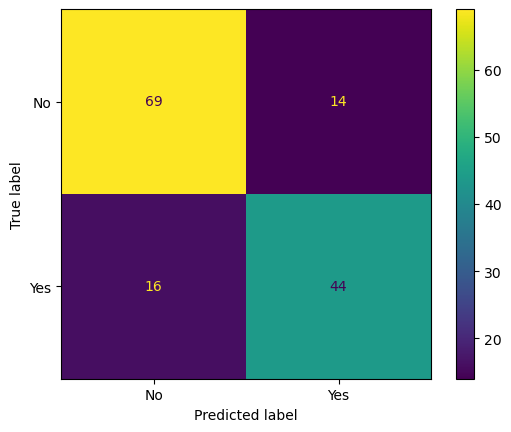

In [83]:
# Step 3: Confusion matrix:
conf_mat = confusion_matrix(y_test, predictions_data_testing)
conf_mat_display = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels) # Per veure la matriu de confusió bonica
conf_mat_display.plot()
plt.show()

C:\Users\mcr99\anaconda3\envs\environment_uoc20242pec3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


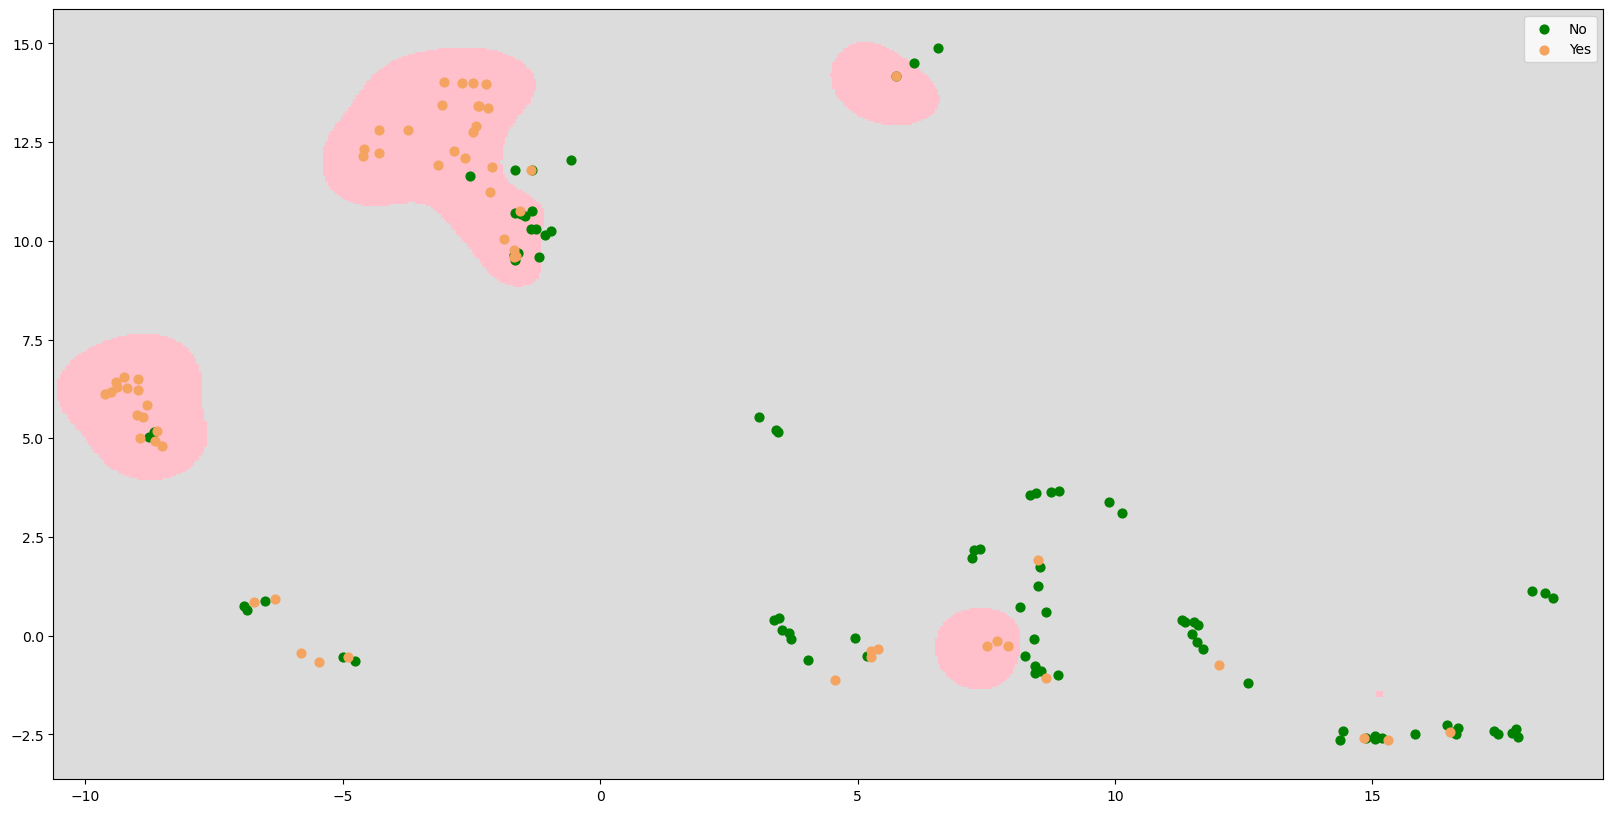

In [85]:
# Step 4: Boundaries
plot_decision_boundaries(svm_optimal, X_test_projection, y_test)

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong>

1.  Comenta els resultats obtinguts en la cerca dels millors hiperparàmetres. Reflexiona sobre com va variar el rendiment del model SVM amb els diferents valors de _C_ i _gamma_. Considera si els valors òptims trobats tenen sentit en el context del teu conjunt de dades.
2.  Examina les fronteres de decisió que has generat amb el model SVM. La forma d'aquestes fronteres és coherent amb el que esperaries de l'algorisme utilitzat? Pensa en com la combinació d'hiperparàmetres seleccionats podria influir en la forma de les fronteres.
3.  Avalua les prediccions realitzades sobre el conjunt de test. Observa'n la precisió i com es distribueixen en relació amb les fronteres de decisió. Són consistents aquestes prediccions amb el que observes a les fronteres de decisió?

Aquesta anàlisi t'ajudarà a comprendre l'eficàcia del model SVM amb els hiperparàmetres seleccionats i el seu impacte en la classificació de les dades.
</div>

<div class="alert alert-block alert-success">
<strong>Resposta:

Anàlisi punt 1 -> Observant la taula de resultats, es pot observar una tendència a l'alça de les mètriques d'accuracy tant en l'entrenament com en el testing, exceptuant alguna combinació dels paràmetres molt concreta que trenca aquesta tendència a alcista. Observant els valors de tots els casos es pot observar que la accuracy d'entrenament tendeix a 0.78 i la de testing a 0.75. Aquesta afirmació és correcta atesa la baixa desviació en ambdós casos. En la cel·la de continuació, es poden veure els càlculs.

Anàlisi punt 2 -> En el mapa s'observa que la classe predominant és el "no" ja que ocupa la major part del mapa. Per la classe del "sí" s'observen "petites illes" on es concentren els punts de color taronja. Les "illes" més petites són aquelles on el model té més probabilitats d'equivocar-se a l'hora de fer la predicció, ja que són regions estretes. Atèsos els valors de C i gamma la forma de les fronteres és coherent.

Anàlisi punt 3 -> Si s'observen tant el gràfic de les fronteres de decisió com la matriu de confusió es pot veure que les distribucions són consistents amb el que s'observa a la matriu. Tot i que en el gràfic de fronteres hi ha algun punt que està al límit entre les dues classes i això pot portar a confusió a l'hora de determinar si el model les considera d'una o altra classe.
</strong>


</div>

In [88]:
print(df_results['mean_train_score'].mean())
print(df_results['std_train_score'].mean())
print(df_results['mean_test_score'].mean())
print(df_results['std_train_score'].mean())

0.7868167121099453
0.006472132009658795
0.7508022268059529
0.006472132009658795


**Material extern consultat:**

[A Man Kumar.(17/12/2018)._C and Gamma in SVM_.Medium](https://medium.com/@myselfaman12345/c-and-gamma-in-svm-e6cee48626be)

<a id='ej14'></a>
## 1.4. Arbres de decisió (1.25 punts)

En aquesta secció, exploraràs els arbres de decisió, models predictius que es basen en regles binàries (sí/no) per classificar les observacions segons els seus atributs i predir el valor de la variable resposta. Aquests arbres poden ser classificadors, com en el teu exemple, o regressors per predir variables contínues.

#### Construcció d'un Arbre

Per construir un arbre, segueix l'algorisme de *recursive binary splitting*:

1.  Comença a la part superior de l'arbre, on totes les observacions pertanyen a la mateixa regió.
2.  Identifica tots els possibles punts de tall per a cadascun dels predictors. Aquests punts de tall són els diferents nivells dels predictors.
3.  Avalua les possibles divisions per a cada predictor utilitzant una mesura específica. En els classificadors, aquestes mesures poden ser el *classification error rate*, l'índex Gini, l'entropia o el chi-quadrat.

Comprendre aquests passos t'ajudarà a entendre com els arbres de decisió creen divisions binàries per classificar les dades i com aquests es poden aplicar tant per a classificació com per a regressió.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong>

Segueix aquests passos:

1.  Amb el dataset d'entrenament, entrena un arbre de decisió utilitzant el classificador `DecisionTreeClassifier` de la biblioteca `tree` de `sklearn`.
2.  Calcula l'_accuracy_ (precisió) del model tant en les dades de _train_ com de _test_.
3.  Calcula la matriu de confusió utilitzant les dades de _test_.
4.  Representa gràficament la frontera de decisió amb les dades de _test_.
5.  Representa l'arbre de decisió. Pots utilitzar el comandament `plot.tree` de la biblioteca `tree` de `sklearn`.

Aquests passos et permetran avaluar com l'arbre de decisió es comporta en el teu conjunt de dades, tant en termes de classificació com en la seva representació visual.
</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong>

1.  Avalua i comenta els resultats obtinguts amb l'arbre de decisió. Considera tant l'_accuracy_ del model en els conjunts de _train_ i _test_ com els resultats de la matriu de confusió.
2.  Reflexiona sobre com la frontera de decisió visualitzada en el conjunt de _test_ s'alinea amb els resultats obtinguts. És coherent amb el que esperaries d'un arbre de decisió?
3.  Observa la representació gràfica de l'arbre. Analitza com les diferents ramificacions i decisions preses a l'arbre expliquen el comportament del model i el seu impacte en la classificació de les dades.

Aquesta anàlisi t'ajudarà a comprendre en profunditat el funcionament i l'eficàcia de l'arbre de decisió en el teu conjunt de dades específic.

</div>

<div class="alert alert-block alert-success">
<strong>Resposta:</strong>


</div>

#### Evitant l'*overfitting*

El procés de construcció d'arbres descrit tendeix a reduir ràpidament l'error d'entrenament, per la qual cosa generalment el model s'ajusta molt bé a les observacions utilitzades com a entrenament (conjunt de *train*). Com a conseqüència, els arbres de decisió tendeixen a l'*overfitting*.

Per evitar l'*overfitting* en els arbres de decisió, és crucial que modifiquis certs hiperparàmetres del model de la manera següent:

1.  Utilitza l'hiperparàmetre `max_depth`, que defineix la profunditat màxima de l'arbre. Hauràs d'explorar els valors entre 4 i 10 per trobar l'equilibri adequat entre la complexitat del model i la seva capacitat per generalitzar.
2.  Estableix l'hiperparàmetre `min_samples_split`, que és el nombre mínim d'observacions que ha de tenir una fulla de l'arbre abans de considerar una divisió. Experimenta amb valors com 2, 10, 20, 50 i 100 per assegurar-te que l'arbre no es torni massa específic per a les observacions d'entrenament.

Ajustant aquests hiperparàmetres, podràs controlar la tendència de l'arbre de decisió a sobreajustar-se al conjunt d'entrenament, millorant així la seva capacitat per realitzar prediccions efectives en noves dades.

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong>

1.  Calcula el valor òptim dels hiperparàmetres `max_depth` i `min_samples_split` utilitzant una cerca de reixeta amb validació creuada. Aquest procés t'ajudarà a trobar els valors òptims que evitaran el sobreajustament.
2.  Per a cada combinació de valors, calcula'n la mitjana i la desviació estàndard.
3.  Fes un *heatmap* per visualitzar la precisió segons els diferents valors dels hiperparàmetres.

Utilitza el mòdul `GridSearchCV` de `sklearn` per calcular els millors hiperparàmetres amb el classificador `DecisionTreeClassifier` de `tree` de `sklearn`. Per a la visualització del *heatmap*, empra la llibreria `Seaborn`.

Aquests passos et permetran identificar de manera efectiva i visual els valors de `max_depth` i `min_samples_split` que maximitzen la precisió del teu arbre de decisió, minimitzant el risc de sobreajustament.
</div>

<div class="alert alert-block alert-info">
<strong>Implementació:</strong>


1.  Entrena un arbre de decisió amb el dataset d'entrenament (_train_) utilitzant la millor combinació de paràmetres que hagis trobat.
2.  Calcula l'_accuracy_ (precisió) del model tant en les dades de _train_ com de _test_.
3.  Calcula la matriu de confusió utilitzant les dades de _test_.
4.  Representa gràficament la frontera de decisió amb les dades de _test_.
5.  Representa l'arbre de decisió.

Aquests passos et permetran avaluar com l'arbre de decisió, ajustat amb els hiperparàmetres òptims, es comporta en el teu conjunt de dades, tant en termes de classificació com en la seva representació visual.

</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong>

1.  Avalua i comenta els resultats obtinguts en la cerca dels millors hiperparàmetres. Considera com la combinació òptima de `max_depth` i `min_samples_split` ha impactat el rendiment de l'arbre de decisió.
2.  Examina les fronteres de decisió generades amb el conjunt de _test_. Reflexiona sobre si la forma d'aquestes fronteres és coherent amb el que esperaries d'un arbre de decisió configurat amb aquests hiperparàmetres.
3.  Analitza les prediccions realitzades sobre el conjunt de test. Observa'n la precisió i com es distribueixen en relació amb les fronteres de decisió. Són consistents aquestes prediccions amb l'estructura de l'arbre de decisió i les fronteres observades?

Aquesta anàlisi t'ajudarà a comprendre l'eficàcia de l'arbre de decisió amb els hiperparàmetres seleccionats i el seu impacte en la classificació de les dades.
</div>

<div class="alert alert-block alert-success">
<strong>Resposta:</strong>


</div>

<a id='ej2'></a>
# 2. Comprensió d'algorismes supervisats (3.25 punts)

En aquest exercici aprofundirem en la comprensió dels algorismes supervisats que hem estudiat, en concret, Arbres de decisió i Knn. Per fer-ho treballarem amb un problema de regressió molt senzill (un únic atribut descriptiu) que es resoldria de forma directa amb una regressió lineal.

**IMPORTANT:** En aquest exercici no es poden utilitzar altres models, ni tècniques com a *ensemble learning* ni fer servir altres llibreries diferents de les indicades i importades a l'inici de la PAC. En aquest exercici hem de seguir les indicacions que es proporcionaran a cada secció, on ens centrarem a transformar el problema (dades) per aconseguir resoldre el nostre problema.

En aquest exercici ens donarem suport en la funció *plot\_regression*, la qual ens permetrà representar de forma senzilla les solucions obtingudes.

**NOTA:** En aquest exercici realitzarem moltes anàlisis visuals amb l'objectiu d'aprofundir en els coneixements teòrics vistos al mòdul. Aquest exercici es realitzarà amb una finalitat didàctica; en la realitat sempre cal donar suport en diverses mètriques objectives per al problema que estiguem resolent, a més, per descomptat, de visualitzar si és possible el problema que estiguem resolent.

In [ ]:
def plot_regression(x_train, y_train, x_test, y_test, preds_train=None, preds_test=None):
    plt.figure(figsize=(15, 8))
    plt.scatter(x_train, y_train, s=60, marker='8', label='train')
    plt.scatter(x_test, y_test, s=60, marker='8', label='test')

    if preds_train is not None:
        plt.scatter(x_train, preds_train, s=60, marker='8', label='preds_train')

    if preds_test is not None:
        plt.scatter(x_test, preds_test, s=60, marker='8', label='preds_test')

    plt.legend()
    plt.show()

A la cel·la següent es defineix el conjunt de dades i se separa en entrenament i test, com es pot observar a la gràfica.

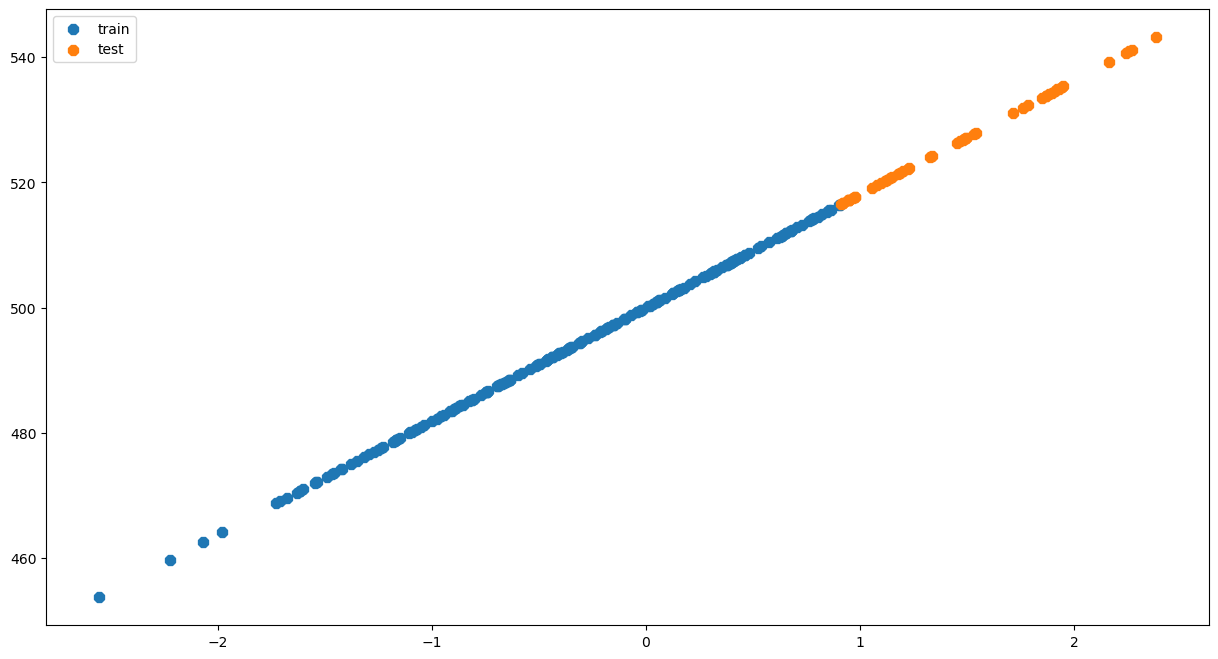

In [ ]:
n_samples = 250
test_size = int(n_samples * 0.2)
X, y = datasets.make_regression(n_features=1, n_samples=n_samples, bias=500, noise=0, random_state=0)
X, y = zip(*sorted(zip(X,y)))
X = np.array(X); y = np.array(y)

X_train = X[:-test_size]
X_test = X[-test_size:]

y_train = y[:-test_size]
y_test = y[-test_size:]

plot_regression(X_train, y_train, X_test, y_test)

<div class="alert alert-block alert-info">
<strong>Implementació:</strong>

1.  Calcula el valor òptim dels hiperparàmetres `max_depth` i `min_samples_split` per a un arbre de decisió utilitzant una cerca de reixeta amb validació creuada i la mètrica 'r2_score'. Aquest procés t'ajudarà a trobar els valors òptims que evitaran el sobreajustament.

2.  Per a cada combinació de valors, calcula'n la mitjana i la desviació estàndard.

3.  Mostra el valor òptim trobat per als dos hiperparàmetres.

4.  Entrena un arbre de decisió amb el dataset d'entrenament (_train_) utilitzant la millor combinació de paràmetres que hagis trobat.

5.  Realitza la predicció sobre el conjunt d'entrenament (_train_) i test per representar gràficament els resultats utilitzant la funció `plot_regression`. Tingues en compte que necessitem visualitzar les 4 sèries: _train_, _test_, predicció sobre _train_ i predicció sobre _test_.

Utilitza el mòdul `GridSearchCV` de `sklearn` per calcular els millors hiperparàmetres amb el classificador `DecisionTreeRegressor` de `tree` de `sklearn`.

</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong>

1.  Analitza visualment les prediccions sobre el conjunt d'entrenament. S'adapta bé el model a aquest conjunt de dades? Hi ha *overfitting*? Per què?
2.  Analitza visualment les prediccions sobre el conjunt de *test*. S'adapta bé el model a aquest conjunt de dades? Per què?
3.  És l'arbre de decisió un bon model per al problema que estem resolent? Per què?

En aquesta anàlisi s'ha de reflexionar sobre els resultats, justificant el comportament del model basant-se en els conceptes teòrics apresos en aquest mòdul.
</div>

<div class="alert alert-block alert-success">
<strong>Resposta:</strong>
</div>

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> En aquesta secció transformarem el problema per ajudar l'arbre de decisió a realitzar millors prediccions. Per fer-ho:

1.  Crea un nou conjunt de dades _transformed\_X\_train_ i _transformed\_X\_test_ a partir dels conjunts originals _X\_train_ i _X\_test_ de manera que cada valor del conjunt transformat sigui la diferència del seu corresponent valor original (en base a la seva posició en el conjunt de dades) menys el valor previ del conjunt original. És a dir: transformed[i] = original[i] - original[i-1]. Presta especial atenció al primer valor del conjunt de dades.

2.  Crea un nou conjunt de dades _transformed\_y\_train_ i _transformed\_y\_test_ a partir dels conjunts originals _y\_train_ i _y\_test_ aplicant la mateixa lògica del punt anterior.

3.  Representa gràficament el nou problema utilitzant la funció `plot_regression`.

Amb aquesta transformació, predirem l'increment de la regressió en lloc del valor absolut.

</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Analitza visualment el nou problema que resoldrem i justifica, basant-te en els conceptes teòrics apresos en aquest mòdul, el motiu pel qual l'arbre de decisió s'hauria d'adaptar millor a aquest problema.
</div>

<div class="alert alert-block alert-success">
<strong>Resposta:</strong>

</div>

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Repetirem el procés d'entrenament i predicció sobre el <strong>nou conjunt de dades transformat</strong>. Per fer-ho:

1.  Calcula el valor òptim dels hiperparàmetres `max_depth` i `min_samples_split` per a un arbre de decisió utilitzant una cerca de reixeta amb validació creuada i la mètrica 'r2_score'. Aquest procés t'ajudarà a trobar els valors òptims que evitaran el sobreajustament.

2.  Per a cada combinació de valors, calcula'n la mitjana i la desviació estàndard.

3.  Mostra el valor òptim trobat per als dos hiperparàmetres.

4.  Entrena un arbre de decisió amb el dataset d'entrenament (_train_) utilitzant la millor combinació de paràmetres que hagis trobat.

5.  Realitza la predicció sobre el conjunt d'entrenament (_train_) i test per representar gràficament els resultats utilitzant la funció `plot_regression`. Tingues en compte que necessitem visualitzar les 4 sèries: _train_, _test_, predicció sobre _train_ i predicció sobre _test_.

Utilitza el mòdul `GridSearchCV` de `sklearn` per calcular els millors hiperparàmetres amb el classificador `DecisionTreeClassifier` de `tree` de `sklearn`.

</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Analitza visualment les prediccions en el nou problema. S'adapta millor l'arbre de decisió al problema?
</div>

<div class="alert alert-block alert-success">
<strong>Resposta:</strong>

</div>

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> En aquesta secció desfarem la transformació aplicada per comprovar si el nou model resol el problema original. Per fer-ho:

1.  Crea un nou conjunt de dades _original\_preds\_train_ i _original\_preds\_test_ a partir dels conjunts originals _preds\_train_ i _preds\_test_ desfent la transformació que hem aplicat al problema. És a dir: original[i] = original[i-1] + transformed[i]. Presta especial atenció al primer valor del conjunt de dades.

2.  Representa gràficament els resultats utilitzant la funció `plot_regression`. Tingues en compte que necessitem visualitzar les 4 sèries: _train_, _test_, predicció sobre _train_ i predicció sobre _test_.

</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Analitza visualment les prediccions transformades al problema original. L'arbre de decisió aconsegueix resoldre el problema original? Per què? Justifica la resposta basant-te en els conceptes teòrics apresos en aquest mòdul.
</div>

<div class="alert alert-block alert-success">
<strong>Resposta:</strong>

</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Com es comportaria el model Knn en el problema original? Obtindria una bona predicció en el conjunt de test? Per què? Justifica la resposta basant-te en els conceptes teòrics apresos en aquest mòdul.
</div>

<div class="alert alert-block alert-success">
<strong>Resposta:</strong>

</div>

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Repetirem el procés d'entrenament i predicció sobre el **nou conjunt de dades transformat** aplicant el model Knn. Per fer-ho:

1.  Calcula el valor òptim de l'hiperparàmetre `n_neighbors` per al regressors `KNeighborsRegressor` de `sklearn` utilitzant una cerca de reixeta amb validació creuada i la mètrica 'r2_score'.

2.  Per a cada combinació de valors, calcula'n la mitjana i la desviació estàndard.

3.  Mostra el valor òptim trobat per als dos hiperparàmetres.

4.  Entrena un arbre de decisió amb el dataset d'entrenament (_train_) utilitzant la millor combinació de paràmetres que hagis trobat.

5.  Realitza la predicció sobre el conjunt d'entrenament (_train_) i test per representar gràficament els resultats utilitzant la funció `plot_regression`. Tingues en compte que necessitem visualitzar les 4 sèries: _train_, _test_, predicció sobre _train_ i predicció sobre _test_.

6.  Desfés la transformació aplicada per comprovar si el nou model resol el problema original. Per fer-ho, crea un nou conjunt de dades _original\_preds\_train_ i _original\_preds\_test_ a partir dels conjunts originals _preds\_train_ i _preds\_test_ desfent la transformació que hem aplicat al problema. És a dir: original[i] = original[i-1] + transformed[i]. Presta especial atenció al primer valor del conjunt de dades.

7.  Representa gràficament els resultats utilitzant la funció `plot_regression`. Tingues en compte que necessitem visualitzar les 4 sèries: _train_, _test_, predicció sobre _train_ i predicció sobre _test_.

Utilitza el mòdul `GridSearchCV` de `sklearn` per calcular els millors hiperparàmetres amb el classificador `KNeighborsRegressor` de `neighbors` de `sklearn`.

</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Analitza visualment les prediccions transformades al problema original. El model Knn aconsegueix resoldre el problema original? Per què? Justifica la resposta basant-te en els conceptes teòrics apresos en aquest mòdul.
</div>

<div class="alert alert-block alert-success">
<strong>Resposta:</strong>

</div>

<a id='ej3'></a>
# 3. Implementació del cas pràctic (3 punts)

El sector bancari ofereix un entorn fascinant per a l'aplicació de tècniques de ciència de dades a causa de la riquesa i diversitat de les seves dades transaccionals i demogràfiques. La predicció de si un titular de préstec complirà amb els seus pagaments no només és crucial per minimitzar riscos financers, sinó també per optimitzar estratègies d'atorgament de crèdits. Aquest problema combina elements de classificació, anàlisi predictiva i detecció de patrons en grans volums de dades. A més, la implementació de models precisos pot millorar la rendibilitat de les institucions financeres i promoure un accés més just al crèdit.

Per a això, utilitzarem el conjunt de dades [bank\_loan\_data](https://www.kaggle.com/datasets/udaymalviya/bank-loan-data), el qual inclou dades sobre 45.000 sol·licituds de préstecs amb diversos atributs relacionats amb dades personals i els detalls del préstec. En concret, el dataset conté 14 característiques:

-   person\_age: Edat del sol·licitant.
-   person\_gender: Gènere del sol·licitant.
-   person\_education: Educació del sol·licitant (High School, Bachelor, Master, etc.).
-   person\_income: Ingressos anuals (en USD).
-   person\_emp\_exp: Anys d'experiència laboral.
-   person\_home\_ownership: Tipus de propietat de l'habitatge (RENT, OWN, MORTGAGE).
-   loan\_amnt: Quantitat del préstec sol·licitat (en USD).
-   loan\_intent: Propòsit del préstec (PERSONAL, EDUCATION, MEDICAL, etc.).
-   loan\_int\_rate: Interès del préstec (percentatge).
-   loan\_percent\_income: Proporció entre la quantitat del préstec i els ingressos.
-   cb\_person\_cred\_hist\_length: Durada de l'historial creditici del sol·licitant.
-   credit\_score: Puntuació creditícia del sol·licitant.
-   previous\_loan\_defaults\_on\_file: Indica si el sol·licitant té incompliments de préstecs previs (Yes or No).
-   loan\_status: variable objectiu, 1 si el préstec va ser pagat i 0 si el sol·licitant va incórrer en impagaments.

L´objectiu d´aquesta secció és abordar l´anàlisi d´aquest conjunt de dades i entrenar arbres de decisió per predir si el préstec serà pagat pel sol·licitant o incórrerà en impagaments. Aquí tens alguns passos que podries seguir:

1.  **Anàlisi Exploratòria de Dades (EDA)**: Comença explorant el conjunt de dades per comprendre la seva estructura i distribució. Analitza la proporció de cada classe. Observa la distribució de les diferents característiques i la seva relació amb la classe objectiu "class".

2.  **Preprocessament de Dades**: Considera normalitzar les característiques perquè estiguin a la mateixa escala que les components principals.

3.  **Modelització**: Utilitza un arbre de decisió com a eina de classificació. Atès que l'objectiu és identificar el nivell de servei del lliurament, és vital centrar-se en mètriques com la precisió, la sensibilitat (recall), el valor F1 i l'àrea sota la corba ROC (AUC-ROC).

4.  **Avaluació**: Realitza una avaluació i anàlisi rigorosa del rendiment del teu model.

Aquest enfocament integral us permetrà no només construir un model efectiu sinó també comprendre millor les característiques subjacents del tipus de préstec en el conjunt de dades.

<a id='ej31'></a>
## 3.1. Càrrega de dades

El primer que has de fer és carregar el conjunt de dades i visualitzar informació rellevant del mateix. Tingues en compte que en aquest exercici només utilitzarem 20000 registres del dataset. Assegura't de verificar el següent:

1.  Confirma la quantitat total de files i columnes en el DataFrame.
2.  Revisa el nom de cada columna del DataFrame.
3.  Verifica el nombre de valors no nuls en cada columna.
4.  Identifica el tipus de dades de cada columna, que pot ser int, float, object, entre altres.
5.  Comprova la quantitat de memòria utilitzada pel DataFrame.

Aquests passos et proporcionaran una comprensió inicial clara i detallada del conjunt de dades amb el qual estàs treballant.

<a id='ej32'></a>
## 3.2. Anàlisi Exploratòria de Dades (EDA) (1 punt)

L'Anàlisi Exploratòria de Dades (EDA, per les seves sigles en anglès) en ciència de dades és un enfocament inicial per comprendre i resumir el contingut d'un conjunt de dades. Aquest procés implica diverses tècniques i passos:

1.  **Inspecció de Dades**: Es comença per revisar les dades brutes per identificar-ne l'estructura, la mida i el tipus (com a numèric, categòric). Això inclou detectar valors faltants o inusuals.

2.  **Resum Estadístic**: Es calculen estadístiques descriptives com la mitjana, la mediana, el rang, la variància i la desviació estàndard per obtenir una idea general de les tendències i els patrons en les dades.

3.  **Visualització de Dades**: S'utilitzen gràfics i diagrames (com ara histogrames, gràfics de caixa, diagrames de dispersió) per visualitzar distribucions, relacions entre variables i possibles anomalies. Això ajuda a comprendre millor les dades i a identificar patrons o irregularitats.

4.  **Anàlisi de Relacions i Correlacions**: S'exploren les relacions entre diferents variables per entendre com s'influencien entre si. Això pot implicar l'ús de matrius de correlació i gràfics de dispersió.

5.  **Identificació de Patrons i Anomalies**: Es busquen patrons consistents o anomalies (com ara valors atípics) que puguin suggerir tendències o problemes en les dades.

L'EDA és una fase crítica en qualsevol projecte de ciència de dades, ja que proporciona una comprensió profunda i una base sòlida per a posteriors anàlisis i modelatge.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong>

1. Calcula les freqüències de la variable objectiu (`loan_status`) en el teu conjunt de dades.
2. Crea un gràfic de barres per visualitzar aquestes freqüències. Això t'ajudarà a entendre la proporció dels préstecs rendibles per al banc en comparació amb els que incorren en impagaments.

A continuació, analitza la distribució de les variables numèriques:

1. Representa gràficament l'histograma de les variables, separant les observacions segons la classe a la qual pertanyen.
2. Organitza tots els histogrames en un format de 4 files i 2 columnes. Això facilitarà la comparació visual de les distribucions per a cada classe en cada variable.

Finalment, analitza la distribució de les variables categòriques de forma anàloga a les variables numèriques, organitzant tots els histogrames en un format de 3 files i 2 columnes.

Aquests passos et permetran obtenir una visió més clara de l'estructura del teu conjunt de dades i com les diferents variables poden influir en la identificació dels impagaments.
</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong>

1. Avalua la relació de les freqüències de la variable `loan_status`. Reflexiona sobre com es distribueixen els préstecs rendibles i els que incorren en impagaments. És la distribució significativament desigual? Què implica això per a l'anàlisi i la modelització de les dades?
2. Analitza la informació proporcionada pels histogrames de les variables descriptores. Observa si hi ha diferències notables en les distribucions d'aquestes variables entre les classes. Pregunta't: Hi ha variables que mostrin patrons distints per a l'estat del préstec?
3. Considera si hi ha altres formes de visualització que podrien ser útils per entendre millor les dades. Per exemple, serien útils els diagrames de caixa (*boxplots*) per visualitzar la distribució de les variables en ambdues classes? Podria un mapa de calor de la matriu de correlació entre variables ajudar-te a entendre les relacions entre elles?

Aquesta anàlisi t'ajudarà a obtenir una comprensió més profunda de la naturalesa de les teves dades i a identificar possibles característiques que podrien ser importants per detectar els préstecs rendibles.
</div>

<div class="alert alert-block alert-success">
<strong>Resposta:</strong>
</div>

<a id='ej33'></a>
## 3.3. Preprocessament de Dades (0.75 punts)

El preprocessament de dades en ciència de dades és un pas crucial que involucra la preparació i transformació de dades brutes en un format adequat per a la seva posterior anàlisi i modelatge. Aquest procés inclou diverses tasques essencials:

1.  **Neteja de Dades**: S'eliminen o es corregeixen dades errònies, incompletes, inexactes o irrellevants. Això pot incloure tractar amb valors faltants, corregir errors d'entrada i gestionar *outliers*.

2.  **Normalització i Escalada**: Les dades es transformen perquè estiguin en una escala comuna, sense distorsionar diferències en els rangs de valors ni perdre informació. Per exemple, escalat min-max o estandardització.

3.  **Codificació de Variables Categòriques**: Les variables categòriques (com ara gènere o país) es converteixen en formats numèrics perquè puguin ser processades per algoritmes d'aprenentatge automàtic, utilitzant tècniques com la codificació *one-hot* o la codificació d'etiquetes.

4.  **Divisió de Dades**: Les dades es divideixen en conjunts d'entrenament, validació i prova, permetent entrenar models, afinar hiperparàmetres i avaluar el rendiment del model de manera efectiva.

5.  **Gestió de Dades Desbalancejades**: En casos de conjunts de dades desbalancejats, s'apliquen tècniques com el sobremostreig o el submostreig per assegurar que el model no estigui biaixat cap a la classe més freqüent.

6.  **Enginyeria de Característiques**: Es creen noves variables (característiques) a partir de les dades existents per millorar la capacitat del model per aprendre patrons i fer prediccions.

El preprocessament és essencial per millorar la qualitat de les dades i fer-les més adequades i efectives per a l'anàlisi i el modelatge en projectes de ciència de dades.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> elimina els atributs categòrics del conjunt de dades i, en el seu lloc, introdueix la transformació d'aquests atributs a tantes variables binàries com categories tinguin. És important que les noves columnes generades siguin de tipus enter. Recorda que la codificació *one-hot* converteix les etiquetes categòriques en vectors binaris. En aquests vectors, el valor d'1 s'assigna a la posició corresponent a la classe i el valor de 0 a totes les altres posicions. Això facilita que els models d'aprenentatge automàtic processin i entenguin les etiquetes categòriques.
<hr>
Suggeriment: utilitzeu la funció "get\_dummies" de "pandas".

</div>

<div class="alert alert-block alert-info">
<strong>Implementació:</strong>

Ara realitzarem la divisió del conjunt de dades. Per fer-ho, segueix aquests passos:

1. Separa els descriptors de la variable resposta. Assigna els descriptors al conjunt `X` i la variable resposta al conjunt `y`.
2. Divideix el *dataset* en dos subconjunts: un per a entrenament (*train*) i un altre per a proves (*test*). Assigna el 80% de les dades al conjunt d'entrenament (`X_train`, `y_train`) i el 20% al conjunt de proves (`X_test`, `y_test`). Utilitza la funció `train_test_split` de la biblioteca `model_selection` de `sklearn`. Assegura't d'utilitzar `random_state = 24` i fes una divisió estratificada per mantenir la mateixa proporció de classes en ambdós conjunts.

</div>

<div class="alert alert-block alert-info">
<strong>Implementació:</strong>

1. Normalitza els descriptors utilitzant l'`StandardScaler` d'`sklearn`. Això estandarditzarà les característiques restant la mitjana i dividint per la desviació estàndard.
2. Mostra les dimensions del conjunt de descriptors original, del conjunt d'entrenament i del conjunt de prova. Això et permetrà veure com s'han dividit les dades.

<strong>Nota:</strong> Ajusta l'`StandardScaler` únicament amb els descriptors d'entrenament per evitar la fuga d'informació o '*data leakage*'. La fuga d'informació ocorre quan s'utilitza informació del conjunt de prova o validació en el procés d'ajust del model. És a dir, si ajustes el model d'escalat amb tot el conjunt de dades, estaries utilitzant informació del conjunt de prova o validació en l'ajust, la qual cosa podria donar la impressió que el model és més precís del que realment és. Per tant, assegura't d'ajustar l'`StandardScaler` només amb les dades d'entrenament i després aplicar-lo als conjunts d'entrenament i prova.
</div>

<a id='ej34'></a>
## 3.4. Modelització (1.25 punts)

La modelització és una fase crucial en què hem de prendre moltes decisions i ser molt rigorosos amb la metodologia. Diversos dels punts clau en aquesta fase són els següents:

-   **Selecció i configuració del model**: Triar l'algoritme de classificació més adequat segons el problema, les dades i els objectius (per exemple, SVM, arbres de decisió, etc.), definint també els criteris d'avaluació.

-   **Entrenament i ajust d'hiperparàmetres**: Entrenar el model amb les dades disponibles i realitzar una cerca d'hiperparàmetres (*grid search*, *random search* o tècniques bayesianes).

-   **Avaluació i validació del model**: Mesurar el rendiment del model amb mètriques adequades (precisió, *recall*, *F1-score*, AUC, etc.) i validar el seu comportament amb tècniques com la validació creuada.

-   **Explicabilitat del model**: Analitzar i interpretar com i per què el model pren decisions, utilitzant eines com coeficients, SHAP, LIME o visualització de vectors de suport, per assegurar transparència i confiança en l'ús del model.

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong> Aquest exercici l'abordarem utilitzant un model d'arbre de decisió. Per fer-ho:

1. Defineix un classificador `DecisionTreeClassifier` de la biblioteca `tree` d'`sklearn` sense especificar cap paràmetre i calcula la seva precisió sobre el conjunt d'entrenament aplicant validació creuada amb 5 conjunts.
2. Entrena un nou model sobre el conjunt de dades d'entrenament.
3. Calcula les mètriques següents tant en les dades d'entrenament (*train*) com de prova (*test*):
    - Calcula l'exactitud (*accuracy*) per mesurar la correcció de les prediccions.
    - Calcula el valor F1, que és una mesura que combina precisió i sensibilitat.
4. Calcula la matriu de confusió utilitzant les dades de prova (*test*).

Utiliza el módulo `cross_val_score` de `sklearn` para aplicar la validación cruzada con el clasificador DecisionTree (de `DecisionTreeClassifier` de `sklearn`).

</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong>

1. Realitza una anàlisi dels resultats i decideix si consideres que aquest model és acceptable.
2. Avalua quina de les mesures de rendiment utilitzades és la més apropiada.
3. Examina la distribució de les classes i planteja una estratègia, si és necessari, per assegurar la fiabilitat de l'estudi realitzat.
</div>

<div class="alert alert-block alert-success">
<strong>Resposta:</strong>
</div>

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong> Repeteix el procediment anterior considerant l'estratègia que consideris necessària per millorar la fiabilitat del model.
</div>

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong> Els arbres de decisió ens permeten calcular la contribució relativa de cada atribut descriptiu al rendiment predictiu del model. Per fer-ho,

1. Calcula la contribució relativa de cada atribut utilitzant l'atribut `feature_importances_`.
2. Crea un DataFrame que contingui dues columnes: el nom de l'atribut descriptiu i la seva contribució.
3. Ordena les files pel valor de contribució.
4. Mostra el DataFrame resultant.

</div>

<div class="alert alert-block alert-danger">
<strong>Solució:</strong>
</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong>

Relaciona la interpretació de la contribució dels atributs descriptius amb l'anàlisi exploratòria de les dades realitzada a l'exercici 3.2.
</div>

<div class="alert alert-block alert-success">
<strong>Resposta:</strong>
</div>